<a href="https://colab.research.google.com/github/Elisabeths25/NLP-Emotion-Analyst-by-Text/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Input, Activation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [4]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/Assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Assignment/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

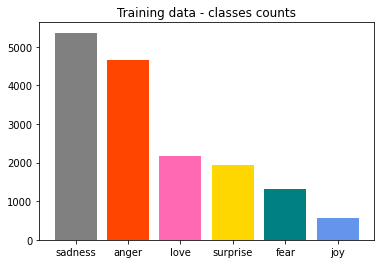

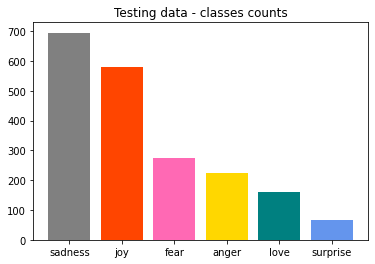

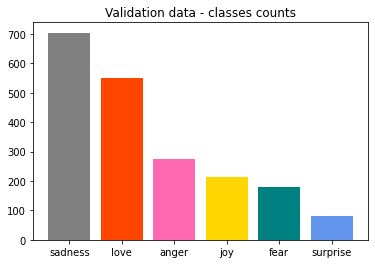

In [5]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(x=pd.Series.unique(y_train), height=pd.Series.value_counts(y_train), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(x=pd.Series.unique(y_test), height=pd.Series.value_counts(y_test), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(x=pd.Series.unique(y_val), height=pd.Series.value_counts(y_val), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [6]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

y_train = y_train
y_test = y_test
y_val = y_val

In [7]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [8]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [24]:

# Build neural network architecture
model = Sequential()
model.add(Embedding(vocabSize, embedding_dim, input_length=256, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

adam = Adam(learning_rate=0.005)
model.compile(loss='sparse_categorical_crossentropy',optimizer = adam ,metrics=["accuracy"])

In [25]:
#Callback
callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=False
)

In [27]:
# Fit model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[callback], verbose=1)

Epoch 1/20
500/500 [==============================] - 291s 582ms/step - loss: 0.2803 - accuracy: 0.9007 - val_loss: 0.2018 - val_accuracy: 0.9145
Epoch 2/20
500/500 [==============================] - 277s 554ms/step - loss: 0.1848 - accuracy: 0.9216 - val_loss: 0.1799 - val_accuracy: 0.9200
Epoch 3/20
500/500 [==============================] - 280s 560ms/step - loss: 0.1540 - accuracy: 0.9305 - val_loss: 0.1490 - val_accuracy: 0.9250
Epoch 4/20
500/500 [==============================] - 283s 566ms/step - loss: 0.1424 - accuracy: 0.9333 - val_loss: 0.1600 - val_accuracy: 0.9215
Epoch 5/20
500/500 [==============================] - 283s 565ms/step - loss: 0.1225 - accuracy: 0.9379 - val_loss: 0.1429 - val_accuracy: 0.9275
Epoch 6/20
500/500 [==============================] - 294s 587ms/step - loss: 0.1221 - accuracy: 0.9388 - val_loss: 0.1657 - val_accuracy: 0.9225
Epoch 7/20
500/500 [==============================] - 296s 591ms/step - loss: 0.1262 - accuracy: 0.9367 - val_loss: 0.1380 -

In [28]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 10s 159ms/step - loss: 0.1224 - accuracy: 0.9405


[0.12239077687263489, 0.940500020980835]

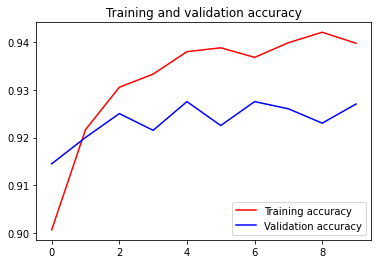

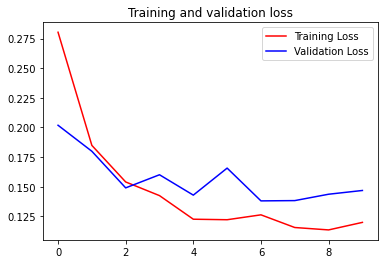

In [29]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# Classify custom sample

sentences = ["i realy scare"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

i realy scare
fear : 0.6913325786590576



In [32]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')